# Restoring causality to hydrostatic vertical motion
### via spherical harmonics analysis of the prognostic equation for horizontal divergence

Take the time derivative of the p-ccordinate mass continuity equation:

$ \partial_t(\partial_p \omega) = - \partial_t(\nabla_p \cdot \vec V) $

Commuting and substituting the horizontal momentum equation on the right yields

$   = -\nabla \cdot \partial_t V $

$ = -\nabla \cdot (HADV + VADV + PGF + COR + FRI) $

with HADV = horizontal advective tendency of V, VADV = vertical advection, PGF = $- \nabla \Phi$, COR = $f \vec V \times \hat k$, and FRI stands in for the whole residual, treating the LHS as observed (from a time sequence of reanalyses). Of course that residual actually includes all the errors in all the reanalysis estimates of all the other terms. 

In [27]:
153.6/32.

4.8

#### To interpret the results, divide potentials by g to get Z units

First we construct the spherical harmonics of all the vector forces in parentheses above, compute their 'velocity potential' functions $ \chi $ (one anti-derivative, better for the human eye to see the global patterns), and divide by g to give it m units. Of course we also compute the divergence of acceleration, the desired result. While at it, we may as well also compute the curl and 'streamfunction' $ \psi $ of all those force-vector fields. 

In [1]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt

grav = 9.81 # m/s units 
Omega = 2*np.pi / 86164. #86400. # inverse second units, angular rotation rate of earth

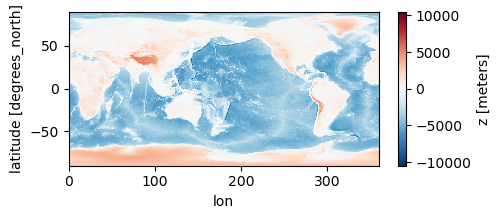

In [24]:
# Subsample DEM for coastline overlays
# DEM = xr.open_dataset('https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/60s/60s_surface_elev_netcdf/ETOPO_2022_v1_60s_N90W180_surface.nc')
# DEM.z[::30,::30].to_netcdf('./DEM.halfdeg.nc')  ## Every 30x30th gridpoint 

DEM05 = xr.open_dataset('./DEM.halfdeg.nc')
# roll to 0-360 lon form, thanks chatGPT for the quickie
DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2))
DEM05['lon'] = (DEM05['lon'] + 180) % 360
DEM05.z.plot(size=2,aspect=2.5) # .contour(vmin=0, vmax=0.01)

# Import ERA5 as a 4D dataset (lat-lon-lev-time)
## Select middle time (with dw/dt variable in it) as e53d
Also, compute a 'dp_over_g' variable for vertical integration later, crudely as 'diff' (better methods [here](https://gist.github.com/spencerkclark/bae91200c3d2c1b59adcd831b1594a2e) if needed)

In [4]:
e54d = xr.open_dataset('/Users/bmapes/Box/era5_3D_3hours_20140916.nc')
e54d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32, time: 3)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2014-09-16T10:00:00 ... 2014-09-16T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
# Calculate downward-forward diff of  'level' coordinate and assign it to a new data array 'dp_over_g'
# It is NaN for the 10mb level, as we slice off that coordinate with [1:]

dp_values = xr.DataArray(e54d['level'].diff('level'), dims=['level'], 
                         coords={'level': e54d['level'][1:]})
e54d['dp_over_g'] = dp_values*100./9.81  # dp/g in kg/m2 units 

In [6]:
# Select central time (index 1 out of 0-1-2) as the 3D fields for spherical analysis 

e53d = e54d.isel({'time':1})
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables:
    z          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
    w          (level, latitude, longitude) float32 ...
    dp_over_g  (level) float64 nan 101.9 101.9 203.9 ... 254.8 254.8 254.8 254.8
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

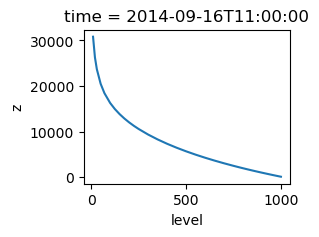

In [10]:
# Grab actual Z, and construct its global profile

Z = e53d['z']/grav

weights = np.cos(np.deg2rad(Z.latitude))
weights.name = "weights"
weights
globalZ = Z.weighted(weights).mean(("longitude", "latitude"))
globalZ.plot(size=2) 

-------------
# Interface with the spherical harmonics package (windspharm)
### "VectorWind" object for that package is really *specific force* (acceleration) fields here.  

---------------
## Coriolis force fVxk, computed from u and v fields

Its potential could be called "geostrophic geopotential", and it explains most of actual Z as we shall see. The next order is Z_ageo, the ageostrophic geopoential.

In [25]:
u = e53d['u']
v = e53d['v']

f = 2*Omega * np.sin(u.latitude *np.pi/180.) 
CORx = v*f
CORy = -u*f

# VectorWind can be any vector field, east and north components. Here FORCES.
# COR = fV x k-hat:
fVxk = windspharm.xarray.VectorWind(CORx, CORy)   

vor_fVxk, div_fVxk = fVxk.vrtdiv()
psi_fVxk, chi_fVxk = fVxk.sfvp()

Z_fVxk = chi_fVxk/grav

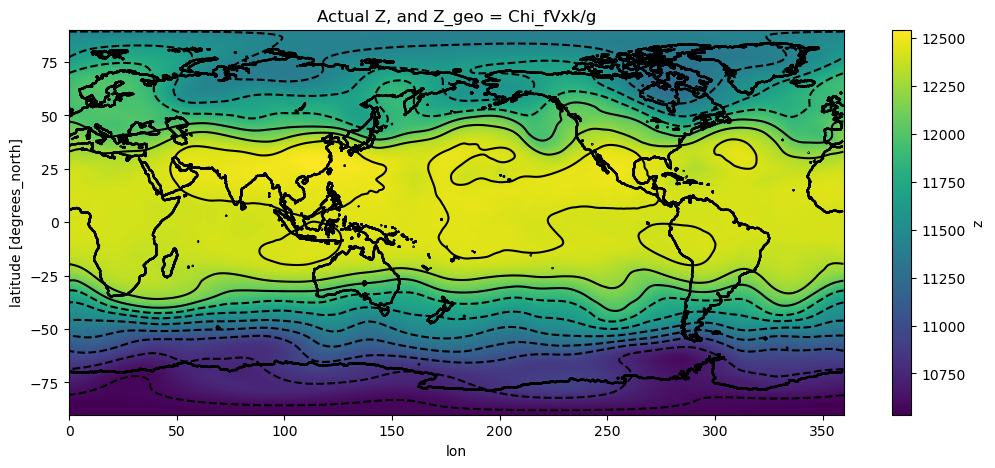

In [11]:
Z.sel(level = 200).plot(size=5, aspect=2.5)
Z_fVxk.sel(level = 200).plot.contour(levels=20, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k');

plt.title('Actual Z, and Z_geo = Chi_fVxk/g');

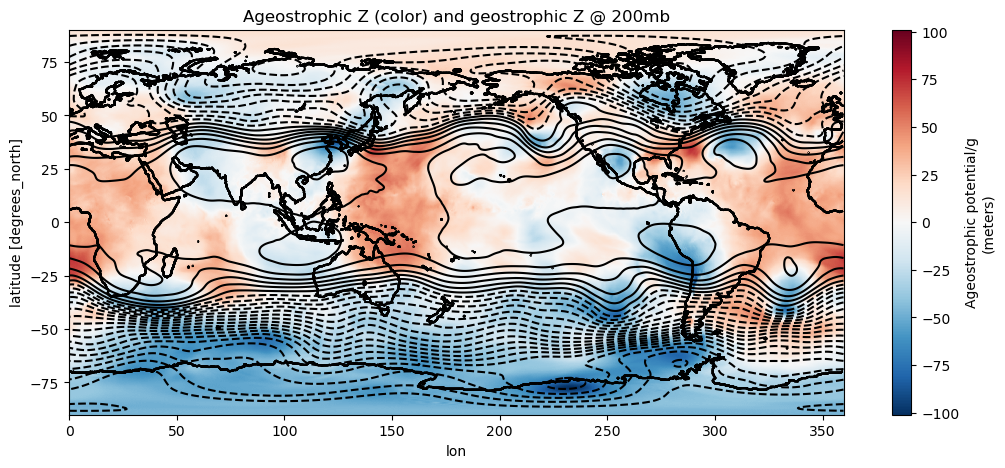

In [16]:
# Ageostrophic: subtract global mean Z(p), and geostrophic Z(x,y,p) 

Z_ageo = Z-globalZ - Z_fVxk
Z_ageo = Z_ageo.rename('Ageostrophic potential/g (meters)')

Z_ageo.sel(level = 200).plot(size=5, aspect=2.5)
Z_fVxk.sel(level = 200).plot.contour(levels=40, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('Ageostrophic Z (color) and geostrophic Z @ 200mb');

---------------
## Horizontal advective acceleration: 
#### the "gradient wind correction" part of ageostrophic geopotential, leaving Z_agra, the "a-gradient" component

Much of Z_ageo is due to curvature of the wind pattern, more generally treated as horizontal advective acceleration

In [17]:
# Advective acceleration
# gradient() method is a property of any windspharm object, like Z_ageo 

du_zon, du_mer = fVxk.gradient(u)
dv_zon, dv_mer = fVxk.gradient(v)

# Vector of horizontal advective accelerations
hadv = windspharm.xarray.VectorWind(
    -(u*du_zon + v*du_mer),
    -(u*dv_zon + v*dv_mer) )

vor_hadv, div_hadv = hadv.vrtdiv()
psi_hadv, chi_hadv = hadv.sfvp()

Z_hadv = chi_hadv/grav

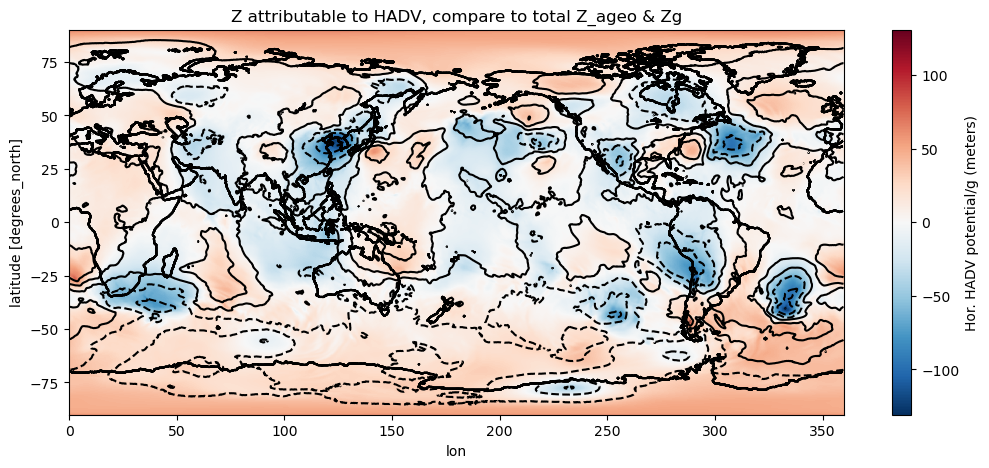

In [23]:
Z_hadv = Z_hadv.rename('Hor. HADV potential/g (meters)')
Z_hadv.sel(level = 200).plot(size=5, aspect=2.5)
Z_ageo.sel(level = 200).plot.contour(levels=10, colors='k')
#Z_fVxk.sel(level = 200).plot.contour(levels=40, colors='g')

DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

plt.title('Z attributable to HADV, compare to total Z_ageo & Zg'); 

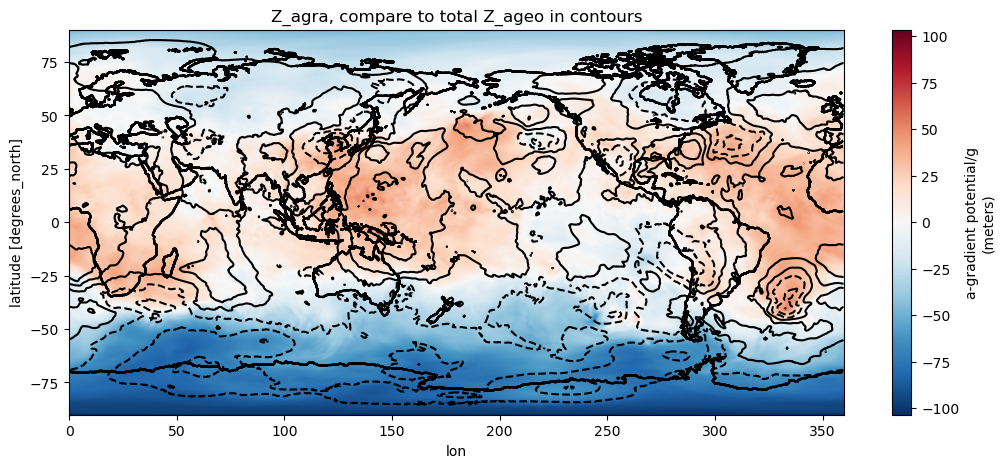

In [348]:
Z_agra = Z_ageo - Z_hadv
Z_agra = Z_agra.rename('a-gradient potential/g (meters)')

Z_agra.sel(level = 200).plot(size=5, aspect=2.5)
Z_ageo.sel(level = 200).plot.contour(levels=10, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

plt.title('Z_agra (colors), compare to total Z_ageo in contours');

---------------
## Vertical advective acceleration: 
e53d.w is in Pa/s, but level is in millibars, so the derivative has to be divided by 100. Sign is software dependent so try to check it in final result. 

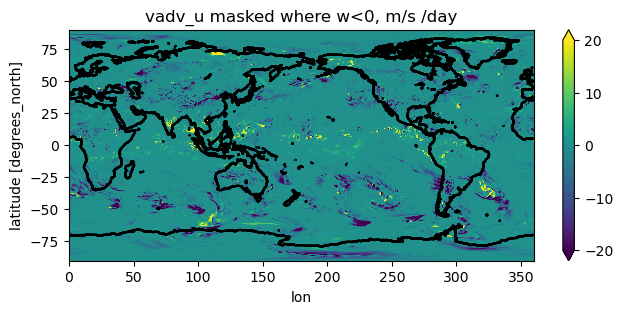

In [299]:
# Check the vertical advection visually at 500mb, 
# seeking synoptic updrafts (w<0) in westerly shear as a visible check

# Try sign as I might think, -w * u.differentiate
vadv_u = -e53d.w * e53d.u.differentiate('level') /100. # 1 m/s per mb = 1/100 m/s per Pa

((86400.*vadv_u*(e53d.w < 0)).sel(level=500)).plot( vmin=-20,vmax=20, size=3,aspect=2.5) # m/s/day 

DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('vadv_u masked where w<0, m/s /day');

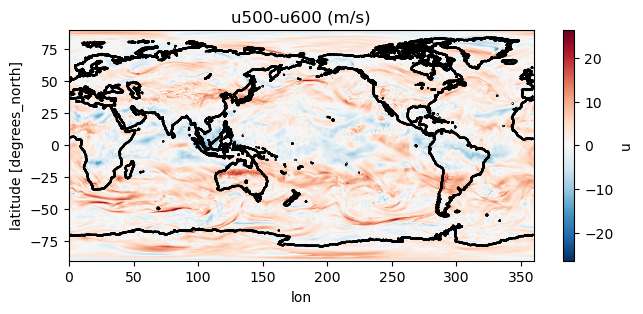

In [301]:
(u.sel(level=500)-u.sel(level=600)).plot(size=3,aspect=2.5)
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('u500-u600 (m/s)');

In [302]:
# Vertical Advective acceleration: 
# Based on above visual check, sign appears to be +w *u.differentiate -- figure out why someday
# Test again below when predicting actual divergent acceleration from all predictors (HADV, VADV) 

vadv_u = e53d.w * e53d.u.differentiate('level') /100. # 1 m/s per mb = 1/100 m/s per Pa
vadv_v = e53d.w * e53d.v.differentiate('level') /100. # 1 m/s per mb = 1/100 m/s per Pa

# Vector of horizontal advective accelerations
vadv = windspharm.xarray.VectorWind(vadv_u, vadv_v)

vor_vadv, div_vadv = vadv.vrtdiv()
psi_vadv, chi_vadv = vadv.sfvp()

Z_vadv = chi_vadv/grav

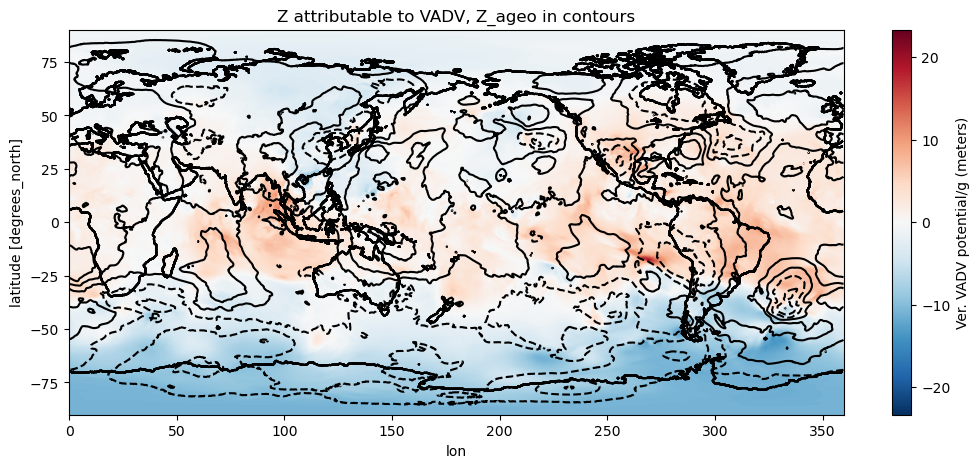

In [351]:
Z_vadv = Z_vadv.rename('Ver. VADV potential/g (meters)')
Z_vadv.sel(level = 200).plot(size=5, aspect=2.5)
Z_ageo.sel(level = 200).plot.contour(levels=10, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')
plt.title('Z attributable to VADV, Z_ageo in contours');

--------------
# Construct time-change (the acceleration to predict, statistically)
Simple centered difference in time of u and v 

In [215]:
dudt = (e54d.u[2]-e54d.u[0]) /2./3600.  # m/s/s units, same as advection 
dvdt = (e54d.v[2]-e54d.v[0]) /2./3600.  # m/s/s units, same as advection 

accel = windspharm.xarray.VectorWind(-dudt,-dvdt) # Negate, 0 = RHS-LHS

vor_accel, div_accel = accel.vrtdiv()
psi_accel, chi_accel = accel.sfvp()

Z_accel = chi_accel/grav

Text(0.5, 1.0, 'Accel potential/g; (Z_ageo-Z_hadv-Z_vadv) in contours')

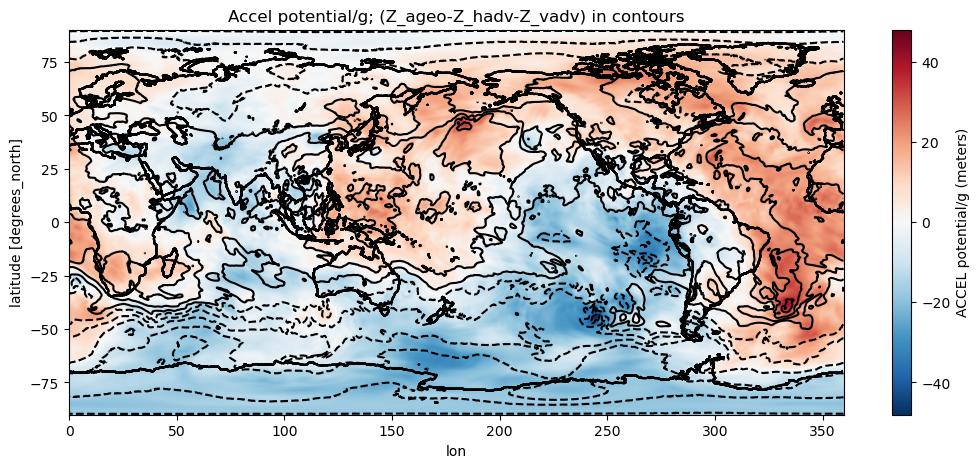

In [309]:
Z_accel = Z_accel.rename('ACCEL potential/g (meters)')
Z_accel.sel(level = 200).plot(size=5, aspect=2.5)
(Z_ageo-Z_hadv-Z_vadv).sel(level = 200).plot.contour(levels=15, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

plt.title('Accel potential/g; (Z_ageo-Z_hadv-Z_vadv) in contours')

# Explore statistical prediction of eddy Z_accel 
### As a function of truncation, so first make truncated data arrays

In [357]:
truncations = [21,42,84,168]
suffixes = ['accel','fVxk','hadv','vadv']

In [355]:
for suf in suffixes: 
    for trunc in truncations: 
        doit = 'Z_'+suf+str(trunc)+' = '+suf+'.velocitypotential(truncation='+str(trunc)+')'
        print(doit); exec(doit)
        print('')

Z_fVxk0 = fVxk.velocitypotential(truncation=0)
Z_fVxk0 = Z_fVxk0 - Z_fVxk0.mean(dim='longitude')

Z_fVxk21 = fVxk.velocitypotential(truncation=21)
Z_fVxk21 = Z_fVxk21 - Z_fVxk21.mean(dim='longitude')

Z_fVxk42 = fVxk.velocitypotential(truncation=42)
Z_fVxk42 = Z_fVxk42 - Z_fVxk42.mean(dim='longitude')

Z_fVxk84 = fVxk.velocitypotential(truncation=84)
Z_fVxk84 = Z_fVxk84 - Z_fVxk84.mean(dim='longitude')

Z_fVxk168 = fVxk.velocitypotential(truncation=168)
Z_fVxk168 = Z_fVxk168 - Z_fVxk168.mean(dim='longitude')

Z_hadv0 = hadv.velocitypotential(truncation=0)
Z_hadv0 = Z_hadv0 - Z_hadv0.mean(dim='longitude')

Z_hadv21 = hadv.velocitypotential(truncation=21)
Z_hadv21 = Z_hadv21 - Z_hadv21.mean(dim='longitude')

Z_hadv42 = hadv.velocitypotential(truncation=42)
Z_hadv42 = Z_hadv42 - Z_hadv42.mean(dim='longitude')

Z_hadv84 = hadv.velocitypotential(truncation=84)
Z_hadv84 = Z_hadv84 - Z_hadv84.mean(dim='longitude')

Z_hadv168 = hadv.velocitypotential(truncation=168)
Z_hadv168 = Z_hadv168 - Z_h

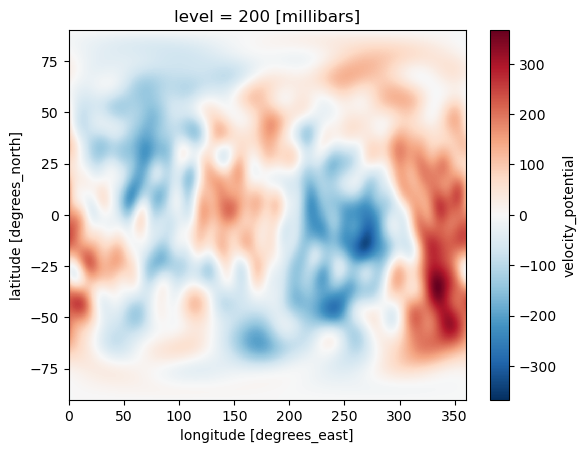

In [341]:
Z_accel21.sel(level=200).plot()

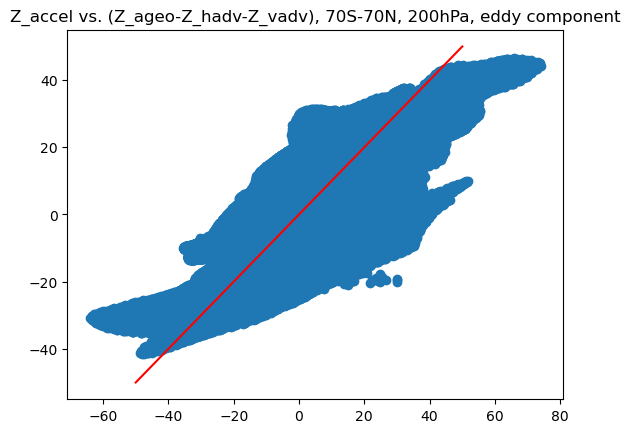

In [308]:
# Scatter plot: are we explaining acceleration as Z - Z_fVxk - Z_hadv - Z_vadv? 
# In tropics? In midlats? play with belt (latitude in reverse order)

belt = slice(70,-70); title='Z_accel vs. (Z_ageo-Z_hadv-Z_vadv), 70S-70N, 200hPa, eddy component'

yyy = Z_accel                .sel(level = 200, latitude=belt)
xxx =(Z_ageo-Z_hadv-Z_vadv)  .sel(level = 200, latitude=belt)

plt.scatter( xxx-xxx.mean(dim='longitude'), 
             yyy-yyy.mean(dim='longitude')  )
plt.plot([-50,50],[-50,50], color='red')

plt.title(title); 

--------------
# Examine the residual (unexplained part) -- any interpretable patterns?
Z_res = Z_ageo - Z_hadv - Z_vadv - Z_accel, has a zonal mean component I don't understand or care as much about so define eddy component (subtracting the zonal mean) 


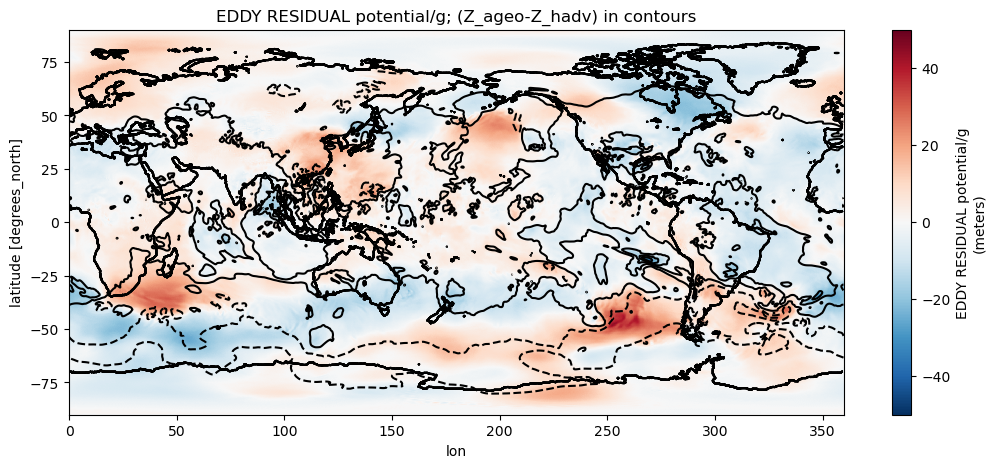

In [307]:
# Imbalance is all kinds of errors and neglected effects 

Z_res = Z_ageo - Z_hadv - Z_vadv - Z_accel 
Z_resid = Z_res-Z_res.mean(dim='longitude')

Z_resid = Z_resid.rename('EDDY RESIDUAL potential/g (meters)')
Z_resid.sel(level = 200).plot(size=5, aspect=2.5)
#(Z_ageo-Z_hadv).sel(level = 200).plot.contour(levels=15, colors='k')
(Z_vadv).sel(level = 200).plot.contour(levels=15, colors='k')
DEM05.z.plot.contour(vmin=0, vmax=0.01, colors='k')

plt.title('EDDY RESIDUAL potential/g; (Z_ageo-Z_hadv) in contours');

# One prooblem: is the Coriolis parameter too weak by about 5% ? 
# TEST: subtract 5% of Zg pattern. Yes indeed! At 200 mb.
# More general: subtract zonal mean


---------------
# Augment e53d dataset and write it out for IDV work 
We want all the Z variables, and maybe others?

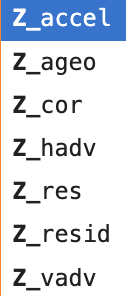
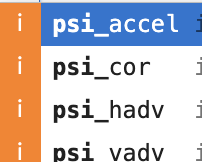

In [360]:
# Augment e53d dataset with EDDY components of Z_ and write it out 

suffixes = ['accel','fVxk','hadv','vadv']
truncations = [21,42,84,168]

dsout = e53d

for suf in suffixes: 
    for trunc in truncations: 
        doit3 = "dsout['Z_" +suf+str(trunc)+"'] = Z_" + suf+str(trunc)
        doit2 = 'Z_'+suf+str(trunc) +' = '+ 'Z_'+suf+str(trunc) +' - '+ \
                'Z_'+suf+str(trunc) +".mean(dim='longitude')"

        print(doit2); exec(doit2)
        print(doit3); exec(doit3)
  
        print('')

Z_accel21 = Z_accel21 - Z_accel21.mean(dim='longitude')
dsout['Z_accel21'] = Z_accel21

Z_accel42 = Z_accel42 - Z_accel42.mean(dim='longitude')
dsout['Z_accel42'] = Z_accel42

Z_accel84 = Z_accel84 - Z_accel84.mean(dim='longitude')
dsout['Z_accel84'] = Z_accel84

Z_accel168 = Z_accel168 - Z_accel168.mean(dim='longitude')
dsout['Z_accel168'] = Z_accel168

Z_fVxk21 = Z_fVxk21 - Z_fVxk21.mean(dim='longitude')
dsout['Z_fVxk21'] = Z_fVxk21

Z_fVxk42 = Z_fVxk42 - Z_fVxk42.mean(dim='longitude')
dsout['Z_fVxk42'] = Z_fVxk42

Z_fVxk84 = Z_fVxk84 - Z_fVxk84.mean(dim='longitude')
dsout['Z_fVxk84'] = Z_fVxk84

Z_fVxk168 = Z_fVxk168 - Z_fVxk168.mean(dim='longitude')
dsout['Z_fVxk168'] = Z_fVxk168

Z_hadv21 = Z_hadv21 - Z_hadv21.mean(dim='longitude')
dsout['Z_hadv21'] = Z_hadv21

Z_hadv42 = Z_hadv42 - Z_hadv42.mean(dim='longitude')
dsout['Z_hadv42'] = Z_hadv42

Z_hadv84 = Z_hadv84 - Z_hadv84.mean(dim='longitude')
dsout['Z_hadv84'] = Z_hadv84

Z_hadv168 = Z_hadv168 - Z_hadv168.mean(dim='longitude')
d

In [361]:
# Include ageo and agra differences for convenience? -- nope I dont have truncations of Z itself
for trunc in truncations: 
    doit4 = "dsout['Z_ageo"+str(trunc)+"'] = Z-Z_fVxk"+str(trunc)
    print(doit4)

dsout['Z_ageo21'] = Z-Z_fVxk21
dsout['Z_ageo42'] = Z-Z_fVxk42
dsout['Z_ageo84'] = Z-Z_fVxk84
dsout['Z_ageo168'] = Z-Z_fVxk168


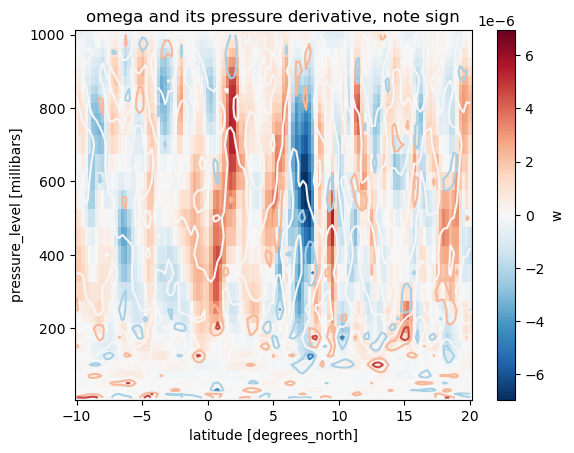

In [387]:
dwdt = (e54d.w[2]-e54d.w[0]) /2./3600.  # Pa/s/s units

dsout['dwdt'] = dwdt 
dsout['d2wdtdp'] = dwdt.differentiate('level')/100.  # /100 because level is in hPa units 
dsout['div_accel'] = div_accel

dwdt.sel(latitude=slice(20,-10)).mean(dim='longitude').plot()

# Check mass continuity: is div_accel the same as dwdt.differentiate('level')? Yes, with factor of 100 Pa/hPa
#dwdt.sel(latitude=slice(20,-10)).differentiate('level').mean(dim='longitude').plot.contour()
div_accel.sel(latitude=slice(20,-10)).mean(dim='longitude').plot.contour()

plt.title('d(omega)/dt and its pressure derivative, note sign');

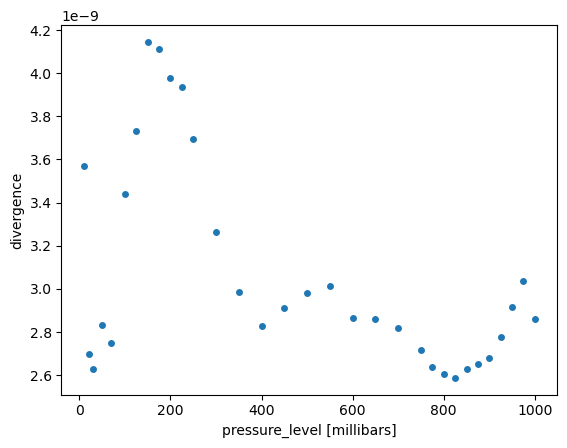

In [396]:
div_accel.sel(latitude=slice(20,-10)).std(dim=['longitude','latitude']).plot.scatter()

In [388]:
dsout

<xarray.Dataset>
Dimensions:     (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude   (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude    (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level       (level) int32 10 20 30 50 70 100 ... 875 900 925 950 975 1000
    time        datetime64[ns] 2014-09-16T11:00:00
Data variables: (12/24)
    z           (level, latitude, longitude) float32 3.028e+05 ... 655.9
    u           (level, latitude, longitude) float32 -0.001392 ... 0.001328
    v           (level, latitude, longitude) float32 -0.001298 ... 0.0008998
    w           (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp_over_g   (level) float64 nan 101.9 101.9 203.9 ... 254.8 254.8 254.8
    dwdt        (level, latitude, longitude) float32 6.858e-07 ... 1.083e-06
    ...          ...
    Z_vadv21    (level, latitude, longitude) float32 -4.387e-05 ... 0.0003662
    Z_vadv42    (level, latitude, longitude) float32 -8.821e-05 ... -0.0003891
    Z_vadv84    (level, latitude, longitude) float32 4.482e-05 ... -1.144e-05
    Z_vadv168   (level, latitude, longitude) float32 -6.819e-05 ... -0.0002098
    d2wdtdp     (level, latitude, longitude) float32 -1.444e-09 ... 2.888e-11
    div_accel   (level, latitude, longitude) float32 -7.966e-09 ... -1.152e-09
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [389]:
dsout.to_netcdf('/Users/bmapes/Box/era5_3D_3hours_20140916_Z_for_divaccel.nc')

In [398]:
dsout.sel(level=[200,550,975]).to_netcdf('/Users/bmapes/Box/era5_3D_3hours_20140916_Z_for_divaccel_200_550_975.nc')

# Vector streamfunction - (from Hakim talk at AMS Keyser symposium) 

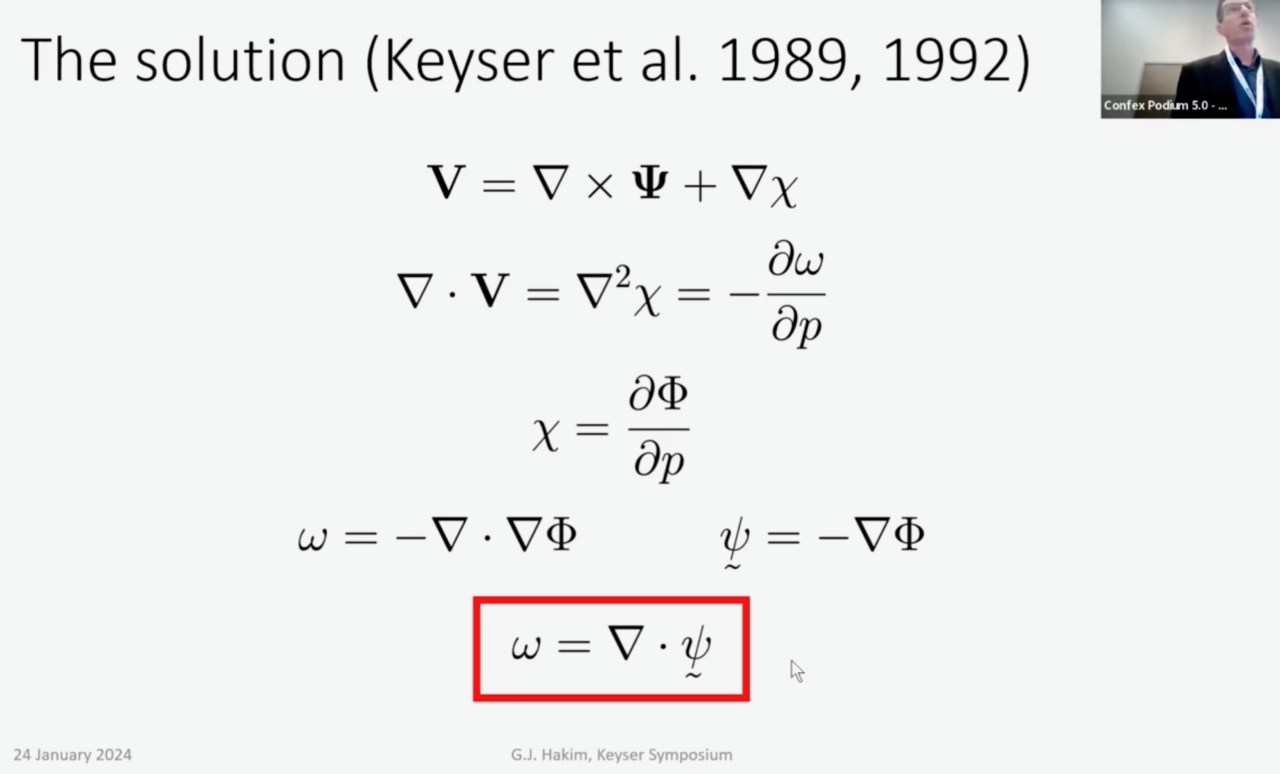 ;